In [176]:
import os
import numpy as np
import pandas
import time
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F

## 1 positional encoding
$PE(pos,2i) = \sin(pos/10000^{2i/d_{model}})$

$PE(pos,2i+1) = \cos(pos/10000^{2i/d_{model}})$

$PE(pos+k,2i) = \sin(pos/10000^{2i/d_{model}})\cos(k/10000^{2i/d_{model}})+ \cos(pos/10000^{2i/d_{model}})\sin(k/10000^{2i/d_{model}}) = PE(pos,2i)PE(k,2i+1)+PE(pos,2i+1)PE(k,2i)$

In [177]:
a = np.arange(10)[:,np.newaxis]
a[1::2,:]

array([[1],
       [3],
       [5],
       [7],
       [9]])

In [178]:
def get_angles(pos, i_dim, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i_dim//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],np.arange(d_model)[np.newaxis, :],d_model)
    
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2]) #even indicies
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2]) #odd indicies
    
    pos_encoding = angle_rads[np.newaxis, ...]
    return torch.tensor(pos_encoding,dtype=torch.float32)

### test positional encoding

torch.Size([1, 10, 16])


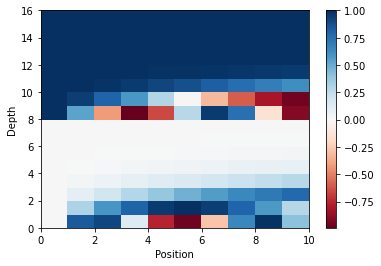

In [179]:
n, d = 10, 16
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = torch.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = torch.transpose(pos_encoding,2,0)
pos_encoding = torch.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

## 2 Masking

In [180]:
def create_padding_mask(seq):
    seq = torch.tensor(torch.eq(seq,torch.tensor(0)), dtype=torch.float32)
    # add extra dimensions to add the padding to the attention logits.
    return seq[:, np.newaxis, np.newaxis, :]  # (batch_size, 1, 1, seq_len)

### test masking

In [181]:
x = torch.tensor([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<ipython-input-180-1ebe6edd47a9>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seq = torch.tensor(torch.eq(seq,torch.tensor(0)), dtype=torch.float32)


tensor([[[[0., 0., 1., 1., 0.]]],


        [[[0., 0., 0., 1., 1.]]],


        [[[1., 1., 1., 0., 0.]]]])

## 3 Scaled dot product attention
dimenstion of Q, K, V matrices:
* q: query shape == (..., seq_len_q, depth)
* k: key shape == (..., seq_len_k, depth)
* v: value shape == (..., seq_len_v, depth_v)

requirements:
* q, k, v must have matching leading dimensions.
* k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
* The mask has different shapes depending on its type(padding or look ahead) but it must be broadcastable for addition.

In [182]:
ar = torch.rand(3, 4)
ar.shape[-1]

4

In [183]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = torch.matmul(q, torch.transpose(k,-2,-1))  # (..., seq_len_q, seq_len_k)
    
    # scale matmul_qk
    dk = torch.tensor(k.shape[-1], dtype=torch.float32)
    scaled_attention_logits = matmul_qk/torch.sqrt(dk)
    
    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    
    # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
    m = nn.Softmax(dim=1)
    attention_weights = m(scaled_attention_logits)
    
    output = torch.matmul(attention_weights, v) # (..., seq_len_q, depth_v)
    
    return output, attention_weights

### test scaled dot product attention

In [184]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print('Attention weights are:')
    print(temp_attn)
    print('Output is:')
    print(temp_out)

np.set_printoptions(suppress=True)
temp_k = torch.tensor([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=torch.float32)  # (4, 3)

temp_v = torch.tensor([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=torch.float32)  # (4, 2)

# This `query` aligns with the second `key`, so the second `value` is returned.
temp_q = torch.tensor([[0, 10, 0]], dtype=torch.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tensor([[8.4333e-26, 1.0000e+00, 8.4333e-26, 8.4333e-26]])
Output is:
tensor([[1.0000e+01, 9.2766e-25]])


In [185]:
# This query aligns with a repeated key (third and fourth), so all associated values get averaged.
temp_q = torch.tensor([[0, 0, 10]], dtype=torch.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tensor([[4.2166e-26, 4.2166e-26, 5.0000e-01, 5.0000e-01]])
Output is:
tensor([[550.0000,   5.5000]])


In [186]:
# This query aligns equally with the first and second key, so their values get averaged.
temp_q = torch.tensor([[10, 10, 0]], dtype=torch.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tensor([[5.0000e-01, 5.0000e-01, 4.2166e-26, 4.2166e-26]])
Output is:
tensor([[5.5000e+00, 4.6383e-25]])


In [187]:
temp_q = torch.tensor([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=torch.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tensor([[4.2166e-26, 4.2166e-26, 5.0000e-01, 5.0000e-01],
        [8.4333e-26, 1.0000e+00, 8.4333e-26, 8.4333e-26],
        [5.0000e-01, 5.0000e-01, 4.2166e-26, 4.2166e-26]])
Output is:
tensor([[5.5000e+02, 5.5000e+00],
        [1.0000e+01, 9.2766e-25],
        [5.5000e+00, 4.6383e-25]])


## 4 Multi-head attention

In [188]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)
        self.dense = nn.Linear(d_model, d_model)
    
    def call(self, v, k, q, mask):
        batch_size = q.shape[0]

        q = self.wq(q).view(batch_size, -1, self.num_heads, self.depth)
        k = self.wk(k).view(batch_size, -1, self.num_heads, self.depth)
        v = self.wv(v).view(batch_size, -1, self.num_heads, self.depth)
        
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = scaled_attention.transpose(1,2)
        concat_attention = torch.reshape(scaled_attention, (batch_size, -1, self.d_model))# (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights
    

### test multi-head attention

In [189]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = torch.rand(1, 60, 512) # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha.call(y, k=y, q=y, mask=None)
out.shape, attn.shape

(torch.Size([1, 60, 512]), torch.Size([1, 8, 60, 60]))

## 5 Point wise feed forward network

In [190]:
class point_wise_feed_forward_network(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__() 
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.linear_2 = nn.Linear(d_ff, d_model)
    def forward(self, x):
        x = F.relu(self.linear_1(x))
        x = self.linear_2(x)
        return x

### test point wise feed forward network

In [191]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(torch.rand((64, 50, 512))).shape

torch.Size([64, 50, 512])

## 6 Normalization

In [192]:
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
        self.size = d_model
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

## 7 Encoder layer and decoder layer

In [193]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = torch.nn.LayerNorm(d_model, eps=1e-6)
        self.layernorm2 = torch.nn.LayerNorm(d_model, eps=1e-6)

        self.dropout1 = torch.nn.Dropout(rate)
        self.dropout2 = torch.nn.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha.call(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

### test encoder layer

In [194]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer.call(torch.rand((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

torch.Size([64, 43, 512])

In [195]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = torch.nn.LayerNorm(d_model, eps=1e-6)
        self.layernorm2 = torch.nn.LayerNorm(d_model, eps=1e-6)
        self.layernorm3 = torch.nn.LayerNorm(d_model, eps=1e-6)

        self.dropout1 = torch.nn.Dropout(rate)
        self.dropout2 = torch.nn.Dropout(rate)
        self.dropout3 = torch.nn.Dropout(rate)

    def call(self, x, enc_output, training,look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1.call(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2.call(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
        
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

### test decoder layer

In [196]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer.call(torch.rand((64, 50, 512)), sample_encoder_layer_output,False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

torch.Size([64, 50, 512])

## 8 Encoder and decoder

In [197]:
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = torch.nn.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = torch.nn.Dropout(rate)

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i].call(x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

### test encoder

In [198]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,dff=2048, input_vocab_size=8500,maximum_position_encoding=10000)
temp_input = torch.tensor(torch.rand((64, 62), dtype=torch.float32)*200, dtype=torch.int64)
sample_encoder_output = sample_encoder.call(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

<ipython-input-198-b836d8e0e9da>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp_input = torch.tensor(torch.rand((64, 62), dtype=torch.float32)*200, dtype=torch.int64)


torch.Size([64, 62, 512])


In [199]:
class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = torch.nn.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = torch.nn.Dropout(rate)

    def call(self, x, enc_output, training,look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i].call(x, enc_output, training,look_ahead_mask, padding_mask)
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

            # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [200]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,dff=2048, target_vocab_size=8000,maximum_position_encoding=5000)
temp_input = torch.tensor(torch.rand((64, 26), dtype=torch.float32)*200, dtype=torch.int64)
output, attn = sample_decoder.call(temp_input,enc_output=sample_encoder_output,training=False,look_ahead_mask=None,padding_mask=None)
output.shape, attn['decoder_layer2_block2'].shape

<ipython-input-200-df9cce0d19fc>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp_input = torch.tensor(torch.rand((64, 26), dtype=torch.float32)*200, dtype=torch.int64)


(torch.Size([64, 26, 512]), torch.Size([64, 8, 26, 62]))

## 9 Transformer

In [203]:
class Transformer(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.tokenizer = Encoder(num_layers, d_model, num_heads, dff,input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,target_vocab_size, pe_target, rate)
        
        self.final_layer = nn.Linear(d_model,target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask,look_ahead_mask, dec_padding_mask):
        
        enc_output = self.tokenizer.call(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder.call(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights


In [204]:
sample_transformer = Transformer(num_layers=2, d_model=512, num_heads=8, dff=2048,input_vocab_size=8500, target_vocab_size=8000,pe_input=10000, pe_target=6000)

temp_input = torch.tensor(torch.rand((64, 38), dtype=torch.float32)*200, dtype=torch.int64)
temp_target = torch.tensor(torch.rand((64, 36), dtype=torch.float32)*200, dtype=torch.int64)

fn_out, _ = sample_transformer.call(temp_input, temp_target, training=False,enc_padding_mask=None,look_ahead_mask=None,dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)



<ipython-input-204-c5b6f04b9873>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp_input = torch.tensor(torch.rand((64, 38), dtype=torch.float32)*200, dtype=torch.int64)
<ipython-input-204-c5b6f04b9873>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp_target = torch.tensor(torch.rand((64, 36), dtype=torch.float32)*200, dtype=torch.int64)


torch.Size([64, 36, 8000])